In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import itertools

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
Racesdf = pd.read_csv('Datasets/races.csv', sep=',')
Racesdf.sort_values(by="date", inplace=True)

Driversdf = pd.read_csv('Datasets/drivers.csv', sep=',')
Driversdf.sort_values(by="driverId", inplace=True)

Resultsdf = pd.read_csv('Datasets/results.csv', sep=',')
ResultsUniquedf = Resultsdf.drop_duplicates(subset=["positionOrder", "raceId"])
ResultsDuplicatedf = Resultsdf[~Resultsdf.index.isin(ResultsUniquedf.index)]

Drivers = {}
Races ={}

In [3]:
def RaceResult(RaceID):
    Positions = Resultsdf.loc[Resultsdf["raceId"]== RaceID, ["positionOrder", "driverId", "raceId"]]
    Positions.sort_values(by="positionOrder", inplace=True)
    forename = Driversdf.set_index("driverId")["forename"]
    surname = Driversdf.set_index("driverId")["surname"]
    year = Racesdf.set_index("raceId")["year"]
    race = Racesdf.set_index("raceId")["name"]

    Positions["Driver"] = Positions["driverId"].map(forename) + " " + Positions["driverId"].map(surname)
    Positions["Race"] = Positions["raceId"].map(year).astype(str) + " " + Positions["raceId"].map(race)
    return Positions

def DriverChecker(DriverList):
    df = pd.DataFrame.from_dict(DriverList, orient="index")
    return df
def RacesChecker(RacesList):
    df = pd.DataFrame.from_dict(RacesList, orient="index")
    return df

def AddDriver(DriverName):
    Drivers[DriverName] = {}
    Drivers[DriverName]["Entries"] = 0
    Drivers[DriverName]["Wins"]= 0
    Drivers[DriverName]["Elo"]= 1300.0
    Drivers[DriverName]["Max Elo"]= 1000.0
    Drivers[DriverName]["Max Elo Race"]= 0
    Drivers[DriverName]["Min Elo"]= 2000.0
    Drivers[DriverName]["Min Elo Race"]= 0
    return

def EloChange(Elo1, Elo2, Result):
    K = 9.0
    P1 = (1/(1+10**((Elo2-Elo1)/400.0)))
    P2 = (1/(1+10**((Elo1-Elo2)/400.0)))
    if Result == "Win":
        NewElo1 = K*(1.0 - P1)
        NewElo2 = K*(0.0 - P2)
    elif Result == "Draw":
        NewElo1 = K*(0.5 - P1)
        NewElo2 = K*(0.5 - P2)
    elif Result == "Loss":
        NewElo1 = K*(0.0 - P1)
        NewElo2 = K*(1.0 - P2)
    else:
        raise ValueError("EloChange result must be Win, Draw or Loss")
    return NewElo1, NewElo2

def RaceCalculator(result):
    Race = result["Race"].values[0]
    ResultDict = dict(zip(result.Driver, result.positionOrder))
    Changes = {}
    Races[Race] = {}
    
    for driver in ResultDict.keys():
        if driver not in Drivers:
            AddDriver(driver)
            Drivers[driver]["First Race"] = Race
        Changes[driver] = 0
        Drivers[driver]["Last Race"] = Race
     
    for driver1, driver2 in itertools.combinations(ResultDict.keys(), 2):
        if ResultDict[driver1] < ResultDict[driver2]:
            a = "Win"
        elif ResultDict[driver1] == ResultDict[driver2]:
            a = "Draw"
        elif ResultDict[driver1] > ResultDict[driver2]:
            a = "Loss"
        else: 
            raise ValueError("Something Happened")
        change1, change2 = EloChange(Drivers[driver1]["Elo"], Drivers[driver2]["Elo"], a)
        Changes[driver1] += change1
        Changes[driver2] += change2

    for driver in ResultDict.keys():
        if ResultDict[driver] == 1:
            Drivers[driver]["Wins"] += 1
        Drivers[driver]["Elo"] += Changes[driver]
        Drivers[driver]["Entries"] += 1
        if Drivers[driver]["Elo"] >= Drivers[driver]["Max Elo"]:
            Drivers[driver]["Max Elo"] = Drivers[driver]["Elo"]
            Drivers[driver]["Max Elo Race"] = Race
        if Drivers[driver]["Elo"] <= Drivers[driver]["Min Elo"]:
            Drivers[driver]["Min Elo"] = Drivers[driver]["Elo"]
            Drivers[driver]["Min Elo Race"] = Race
        Races[Race][driver] = Drivers[driver]["Elo"]
    return

In [4]:
def AllTimeCalculator():
    Drivers.clear()
    Races.clear()
    for ind in Racesdf.index:
        if Racesdf["year"][ind] < 2024:
            a = Racesdf["raceId"][ind]
            RaceCalculator(RaceResult(a))
    
    return Drivers, Races

def SeasonCalculator(Year):
    Drivers.clear()
    Races.clear()
    for ind in Racesdf.index:
        if Racesdf["year"][ind] == Year:
            a = Racesdf["raceId"][ind]
            RaceCalculator(RaceResult(a))
    
    return Drivers

In [5]:
AllTimeCalculator()
a = DriverChecker(Drivers)
b = RacesChecker(Races)
averagea = a["Max Elo"].mean()
SeasonCalculator(2023)
c = DriverChecker(Drivers)
d = RacesChecker(Races)
averageb = c["Max Elo"].mean()



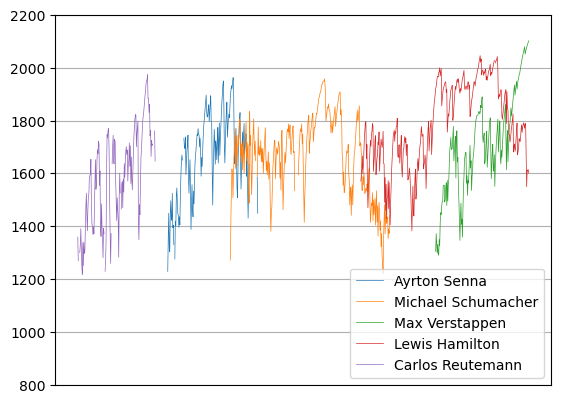

In [6]:

fig, ax = plt.subplots()

ax.plot(b.iloc[0:,651], linewidth = '.5')
ax.plot(b.iloc[0:,702], linewidth = '.5')
ax.plot(b.iloc[0:,830], linewidth = '.5')
ax.plot(b.iloc[0:,794], linewidth = '.5')
ax.plot(b.iloc[0:,504], linewidth = '.5')
ax.grid(which="Major",axis="y")

ax.set_yticks(np.arange(800, 2400, step=200))
ax.set_xticks([])
ax.legend(["Ayrton Senna", "Michael Schumacher","Max Verstappen", "Lewis Hamilton", "Carlos Reutemann"])